In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
mlp_valid_df = pd.read_csv('../03_Data_for_Modeling/val_mlp_new_time_window.csv')
mlp_y_valid = mlp_valid_df['time_window']

xg_valid_df = pd.read_csv('../03_Data_for_Modeling/val_xgboost.csv')
xg_y_valid = xg_valid_df['time_window']

equal = mlp_y_valid.equals(xg_y_valid)
print("Are the Series equal?:", equal)

Are the Series equal?: True


In [3]:
mlp_test_df = pd.read_csv('../03_Data_for_Modeling/test_mlp_new_time_window.csv')
mlp_y_test = mlp_test_df['time_window']

xg_test_df = pd.read_csv('../03_Data_for_Modeling/test_xgboost.csv')
xg_y_test = xg_test_df['time_window']

equal = mlp_y_test.equals(xg_y_test)
print("Are the Series equal?:", equal)

Are the Series equal?: True


### ^ confirms that the MLP and XGBoost datasets are in the same order which is critical

In [4]:
y_valid_df = pd.read_csv('../03_Data_for_Modeling/val_mlp_new_time_window.csv')
y_val = y_valid_df['time_window']

In [5]:
y_test_df = pd.read_csv('../03_Data_for_Modeling/test_mlp_new_time_window.csv')
y_test = y_test_df['time_window']

In [6]:
xgboost_yes4neigh_val_pred_prob = pd.read_csv('../03_Data_for_Modeling/val_xgboost_yes4neigh_ensemble_probabilities.csv')
mlp_val_pred_prob = pd.read_csv('../03_Data_for_Modeling/val_mlp_ensemble_probabilities.csv')

xgboost_yes4neigh_test_pred_prob = pd.read_csv('../03_Data_for_Modeling/test_xgboost_yes4neigh_ensemble_probabilities.csv')
mlp_test_pred_prob = pd.read_csv('../03_Data_for_Modeling/test_mlp_ensemble_probabilities.csv')

In [7]:
mlp_val_pred_prob.columns = [col + '_mlp_prob' for col in mlp_val_pred_prob.columns]
mlp_test_pred_prob.columns = [col + '_mlp_prob' for col in mlp_test_pred_prob.columns]

In [8]:
new_column_names = [
    'rush_morning_xgyes4neigh_prob',
    'rush_evening_xgyes4neigh_prob',
    'non_rush_day_xgyes4neigh_prob',
    'non_rush_night_xgyes4neigh_prob'
]

xgboost_yes4neigh_val_pred_prob.columns = new_column_names

xgboost_yes4neigh_test_pred_prob.columns = new_column_names

In [9]:
ensemble_val_features = pd.concat([mlp_val_pred_prob, xgboost_yes4neigh_val_pred_prob], axis=1)
ensemble_test_features = pd.concat([mlp_test_pred_prob, xgboost_yes4neigh_test_pred_prob], axis=1)

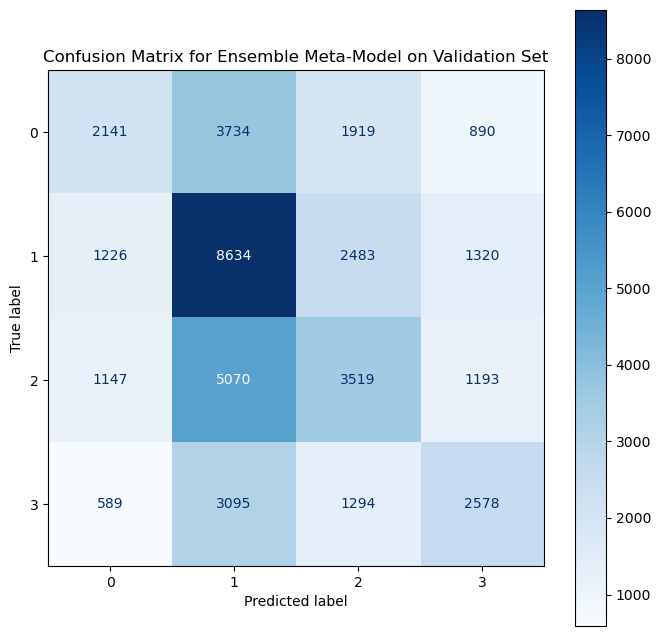

Validation Set Class-wise Metrics:
rush_morning - Precision: 0.42, Recall: 0.25, F1-Score: 0.31
rush_evening - Precision: 0.42, Recall: 0.63, F1-Score: 0.50
non_rush_day - Precision: 0.38, Recall: 0.32, F1-Score: 0.35
non_rush_night - Precision: 0.43, Recall: 0.34, F1-Score: 0.38

Macro Averages:
Precision: 0.41, Recall: 0.39, F1-Score: 0.39

Micro Averages:
Precision: 0.41, Recall: 0.41, F1-Score: 0.41


In [10]:
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

# Train the model
meta_model.fit(ensemble_val_features, y_val)

# Optionally, evaluate the model
y_val_pred = meta_model.predict(ensemble_val_features)
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Ensemble Meta-Model on Validation Set')
plt.show()
class_names = ['rush_morning', 'rush_evening', 'non_rush_day', 'non_rush_night']

# Class-wise precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred, average=None)

print("Validation Set Class-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

# Macro and Micro Averages
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro')
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_val, y_val_pred, average='micro')

print("\nMacro Averages:")
print(f"Precision: {precision_macro:.2f}, Recall: {recall_macro:.2f}, F1-Score: {f1_score_macro:.2f}")

print("\nMicro Averages:")
print(f"Precision: {precision_micro:.2f}, Recall: {recall_micro:.2f}, F1-Score: {f1_score_micro:.2f}")

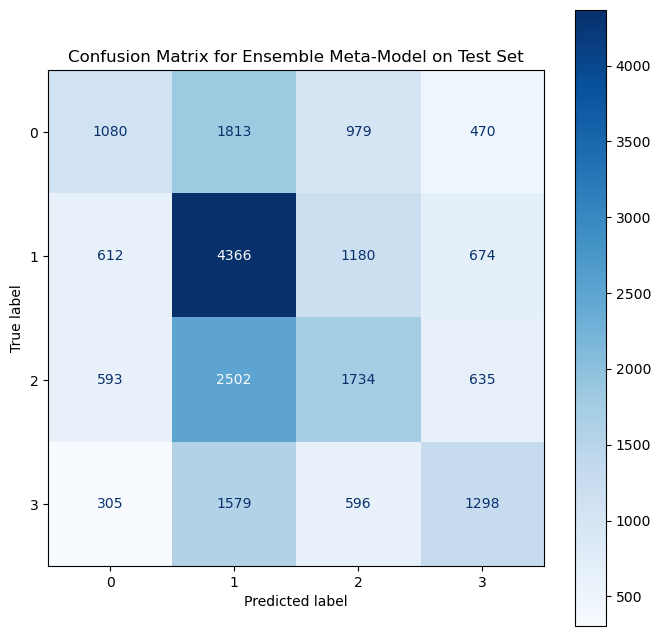

Test Set Class-wise Metrics:
rush_morning - Precision: 0.42, Recall: 0.25, F1-Score: 0.31
rush_evening - Precision: 0.43, Recall: 0.64, F1-Score: 0.51
non_rush_day - Precision: 0.39, Recall: 0.32, F1-Score: 0.35
non_rush_night - Precision: 0.42, Recall: 0.34, F1-Score: 0.38

Test Set Macro Averages:
Precision: 0.41, Recall: 0.39, F1-Score: 0.39

Test Set Micro Averages:
Precision: 0.42, Recall: 0.42, F1-Score: 0.42


In [11]:
y_test_pred = meta_model.predict(ensemble_test_features)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Ensemble Meta-Model on Test Set')
plt.show()

# Class-wise precision, recall, and F1-score
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

print("Test Set Class-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {precision_test[i]:.2f}, Recall: {recall_test[i]:.2f}, F1-Score: {f1_score_test[i]:.2f}")

# Macro and Micro Averages
precision_macro_test, recall_macro_test, f1_score_macro_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')
precision_micro_test, recall_micro_test, f1_score_micro_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='micro')

print("\nTest Set Macro Averages:")
print(f"Precision: {precision_macro_test:.2f}, Recall: {recall_macro_test:.2f}, F1-Score: {f1_score_macro_test:.2f}")

print("\nTest Set Micro Averages:")
print(f"Precision: {precision_micro_test:.2f}, Recall: {recall_micro_test:.2f}, F1-Score: {f1_score_micro_test:.2f}")

/home/jiax1/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jiax1/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


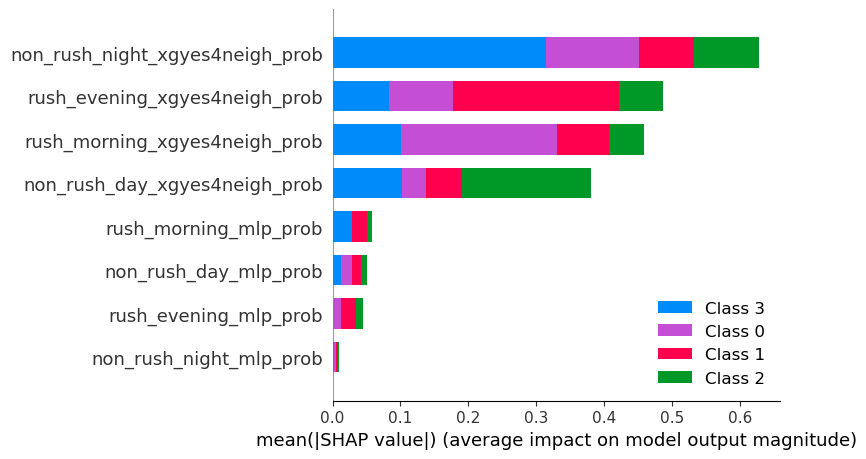

In [12]:
feature_names = ensemble_test_features.columns.tolist()
import shap 
np.int = int
np.bool = bool

explainer = shap.Explainer(meta_model, ensemble_test_features)
shap_values = explainer.shap_values(ensemble_test_features)
shap.summary_plot(shap_values, ensemble_test_features, feature_names=feature_names)

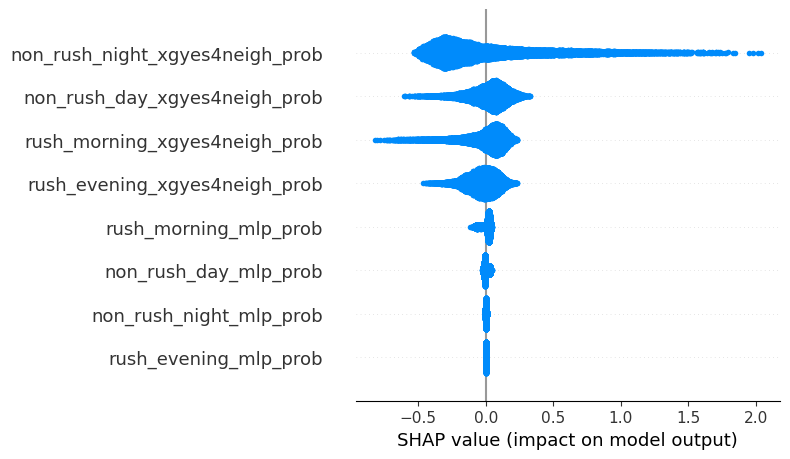

In [13]:
shap.summary_plot(shap_values[3], feature_names)

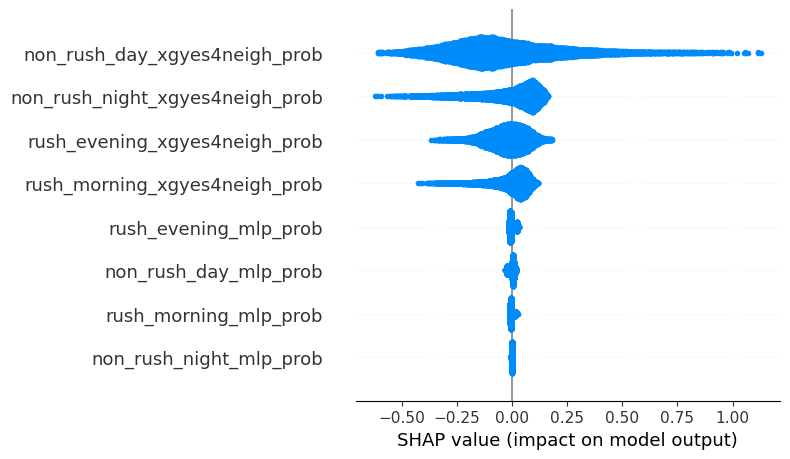

In [14]:
shap.summary_plot(shap_values[2], feature_names)

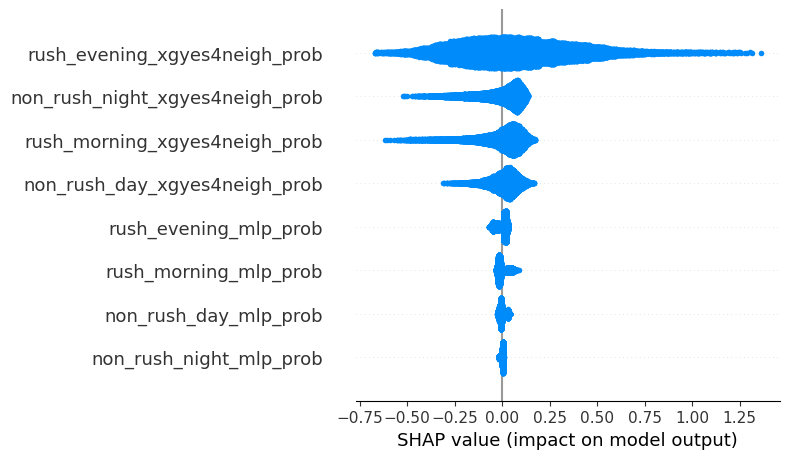

In [15]:
shap.summary_plot(shap_values[1], feature_names)

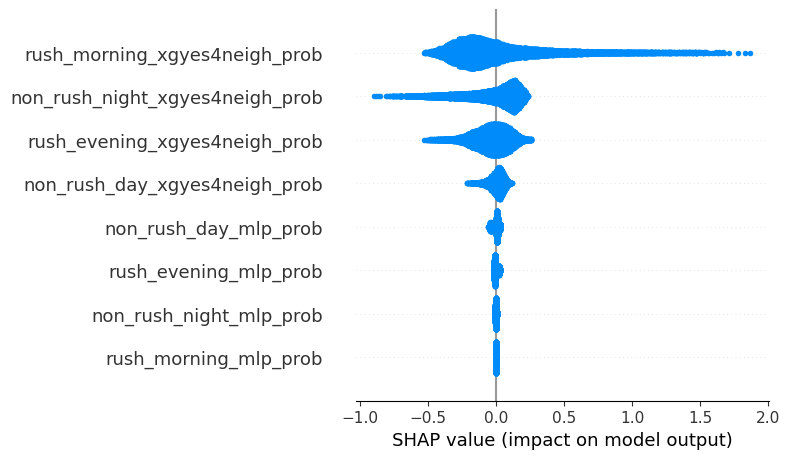

In [16]:
shap.summary_plot(shap_values[0], feature_names)